<a href="https://colab.research.google.com/github/aishamohamed/GAN-Benchmarck/blob/main/classify_resnet_gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DCGAN-Augmented Melanoma Classification

**Author:** Aisha Mohamed
**Supervisor:** Reihaneh Tarlani  
**Course:** ISIC-2017 GAN Benchmarking (Bachelor’s Thesis, Spring 2025)  

This notebook implements an end-to-end pipeline for augmenting a ResNet-18 skin lesion classifier with DCGAN-generated synthetic melanoma images. We compare baseline (real-only) performance with augmented training using 200 and 500 synthetic samples.

## Environment Setup

In [16]:
#imports
import os, glob
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader, Subset, ConcatDataset
from torchvision import transforms as T, datasets
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.optim as optim
from pathlib import Path
from torchvision import models
import torch.nn.functional as F
import torchvision.utils as vutils
from sklearn.metrics import classification_report
import random
import torch
from torch.utils.data import random_split
from collections import defaultdict





# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Running on:", device)


Running on: cuda


In [17]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

SEEDS = [42, 43, 44, 45, 46]


##  Paths & Hyperparameters

In [18]:
# filesystem & paths
from pathlib import Path
BASE     = Path('/content/drive/MyDrive/ISIC2017')
REAL_ROOT= BASE / 'by_class_128'
SYN_ROOT = BASE / 'synthetic_melanoma'
TEST_ROOT= BASE / 'test_by_class'

# hyperparameters
image_size = 128
batch_size = 32
num_epochs = 100
lr         = 1e-4
nz         = 100
nz  = 100
ngf = 64
nc  = 3

## Data Transforms & Loaders

In [19]:
# preprocessing transform
clf_tf = T.Compose([
    T.Resize(image_size),
    T.RandomHorizontalFlip(0.5),
    T.RandomRotation(30),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])
real_ds    = datasets.ImageFolder(str(REAL_ROOT), transform=clf_tf)

# split real_ds to train_real_ds + val_ds (80/20)
n_val    = int(len(real_ds) * 0.2)
n_train  = len(real_ds) - n_val
train_real_ds, val_ds = random_split(
    real_ds, [n_train, n_val],
    generator=torch.Generator().manual_seed(SEED)
)

# Loaders
train_real_loader= DataLoader(real_ds, batch_size=batch_size, shuffle=True,  num_workers=2)
val_loader        = DataLoader(val_ds,        batch_size=batch_size, shuffle=False, num_workers=2)

# Test loader
test_ds    = datasets.ImageFolder(str(TEST_ROOT), transform=clf_tf)
test_loader= DataLoader(test_ds,   batch_size=batch_size, shuffle=False, num_workers=2)

print("Real classes:", real_ds.classes, "=>", len(real_ds))
print("Test   total:", len(test_ds))


Real classes: ['melanoma', 'nevus', 'seborrheic_keratosis'] => 2000
Test   total: 600


## DCGAN Generator Definition & Loading

In [20]:
# Define DCGAN Generator (matches training architecture)
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            # 1×1→4×4
            nn.ConvTranspose2d(nz, ngf*8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf*8),
            nn.ReLU(True),
            # 4→8
            nn.ConvTranspose2d(ngf*8, ngf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*4),
            nn.ReLU(True),
            # 8→16
            nn.ConvTranspose2d(ngf*4, ngf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*2),
            nn.ReLU(True),
            # 16→32
            nn.ConvTranspose2d(ngf*2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # 32→64
            nn.ConvTranspose2d(ngf, ngf//2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf//2),
            nn.ReLU(True),
            # 64→128
            nn.ConvTranspose2d(ngf//2, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )
    def forward(self, x):
        return self.main(x)


# Instantiate & load saved weights
generator = Generator().to(device)

gen_path = '/content/drive/MyDrive/ISIC2017/models/generator_epoch170.pth'
state    = torch.load(gen_path, map_location=device)
generator.load_state_dict(state)

generator.eval()
print("Loaded DCGAN generator from", gen_path)



Loaded DCGAN generator from /content/drive/MyDrive/ISIC2017/models/generator_epoch170.pth


## Define Classifier & Save Initial Weights

In [21]:
def make_classifier(num_classes):
    model = models.resnet18(pretrained=True)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model.to(device)

# initial model & save its “fresh” state for reset
model = make_classifier(len(real_ds.classes))
torch.save(model.state_dict(), '/content/initial_resnet18.pth')

import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Training & Evaluation Routines

In [22]:
def train_one_epoch(dataloader):
    model.train()
    total_loss = 0
    for imgs, labs in dataloader:
        imgs, labs = imgs.to(device), labs.to(device)
        optimizer.zero_grad()
        logits = model(imgs)
        loss   = criterion(logits, labs)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * imgs.size(0)
    return total_loss / len(dataloader.dataset)

from sklearn.metrics import classification_report

@torch.no_grad()
def evaluate(loader):
    model.eval()
    correct = defaultdict(int)
    total   = defaultdict(int)
    all_preds, all_labels = [], []

    for imgs, labs in loader:
        imgs, labs = imgs.to(device), labs.to(device)
        logits     = model(imgs)
        preds      = logits.argmax(dim=1)

        # accumulate per‐class counts
        for p, t in zip(preds, labs):
            idx = int(t)
            total[idx]   += 1
            if int(p) == idx:
                correct[idx] += 1

        all_preds.extend(preds.cpu().tolist())
        all_labels.extend(labs.cpu().tolist())

    # build per‐class accuracy dict
    per_class_acc = {
        cls_idx: correct[cls_idx] / total[cls_idx]
        for cls_idx in total
    }

    return all_labels, all_preds, per_class_acc


##Baseline (Real-Only) Training & Eval

In [23]:
# ─── Baseline (real-only) with multi‐seed ───
baseline_epochs, baseline_recalls = [], []

for seed in SEEDS:
    set_seed(seed)
    print(f"\n===== Baseline seed={seed} =====")
    # reload fresh model & optimizer
    model.load_state_dict(torch.load('/content/initial_resnet18.pth'))
    optimizer = optim.Adam(model.parameters(), lr=lr)


    train_losses_b, val_losses_b = [], []
    best_val    = float('inf')
    stale       = 0
    patience    = 5                # stop if no improvement for 5 epochs
    torch.save(model.state_dict(), 'best_baseline.pth')  # seed a “best” file


    stop_epoch = num_epochs
    for epoch in range(1, num_epochs+1):
        # — train —
        tr_loss = train_one_epoch(train_real_loader)
        train_losses_b.append(tr_loss)
        # — validate —
        running_val_loss = 0.0
        total = 0
        for imgs, labs in val_loader:
            imgs, labs = imgs.to(device), labs.to(device)
            logits = model(imgs)
            running_val_loss += criterion(logits, labs).item() * imgs.size(0)
            total += labs.size(0)
        val_loss = running_val_loss / len(val_ds)
        val_losses_b.append(val_loss)
        print(f"[Baseline] Epoch {epoch}/{num_epochs} Train Loss: {tr_loss:.4f}  Val Loss: {val_loss:.4f}")

        if val_loss < best_val - 1e-4:
          best_val = val_loss
          stale    = 0
          torch.save(model.state_dict(), 'best_baseline.pth')
        else:
          stale += 1
          if stale >= patience:
            stop_epoch = epoch
            print(f"=> Baseline early-stopping at epoch {epoch}")
            break

    # restore best
    model.load_state_dict(torch.load('best_baseline.pth'))
    # — test —
    y_true_base, y_pred_base, per_class_acc_baseline   = evaluate(test_loader)
    print("\nBaseline test report:")
    print(classification_report(y_true_base, y_pred_base, target_names=real_ds.classes))
    print("Per-class accuracy:", per_class_acc_baseline)

    # record
    baseline_epochs.append(stop_epoch)
    baseline_recalls.append(per_class_acc_baseline[0])

print("\nBaseline over seeds:")
print(f"  epochs: {np.mean(baseline_epochs):.1f} ± {np.std(baseline_epochs):.1f}")
print(f"  mel recall: {np.mean(baseline_recalls):.3f} ± {np.std(baseline_recalls):.3f}")


===== Baseline seed=42 =====
[Baseline] Epoch 1/100 Train Loss: 0.7715  Val Loss: 0.5439
[Baseline] Epoch 2/100 Train Loss: 0.5636  Val Loss: 0.5275
[Baseline] Epoch 3/100 Train Loss: 0.4931  Val Loss: 0.4410
[Baseline] Epoch 4/100 Train Loss: 0.4222  Val Loss: 0.3697
[Baseline] Epoch 5/100 Train Loss: 0.3630  Val Loss: 0.2907
[Baseline] Epoch 6/100 Train Loss: 0.3285  Val Loss: 0.2492
[Baseline] Epoch 7/100 Train Loss: 0.2981  Val Loss: 0.2634
[Baseline] Epoch 8/100 Train Loss: 0.2524  Val Loss: 0.1904
[Baseline] Epoch 9/100 Train Loss: 0.2199  Val Loss: 0.2009
[Baseline] Epoch 10/100 Train Loss: 0.1941  Val Loss: 0.1207
[Baseline] Epoch 11/100 Train Loss: 0.1810  Val Loss: 0.1467
[Baseline] Epoch 12/100 Train Loss: 0.1405  Val Loss: 0.0996
[Baseline] Epoch 13/100 Train Loss: 0.1299  Val Loss: 0.0984
[Baseline] Epoch 14/100 Train Loss: 0.1201  Val Loss: 0.0858
[Baseline] Epoch 15/100 Train Loss: 0.1349  Val Loss: 0.0764
[Baseline] Epoch 16/100 Train Loss: 0.0915  Val Loss: 0.0572
[Ba

## Augmentation Subsampling Helper

In [24]:
from torch.utils.data import Subset

def make_aug_loader(n_syn: int):
    full_syn = datasets.ImageFolder(str(SYN_ROOT), transform=clf_tf)
    N = len(full_syn)
    if n_syn > N:
        raise ValueError(f"Requested {n_syn} synthetic > available {N}")
    idxs   = np.random.choice(N, size=n_syn, replace=False).tolist()
    syn_sub= Subset(full_syn, idxs)

    aug_ds = ConcatDataset([train_real_ds, syn_sub])
    loader = DataLoader(
        aug_ds, batch_size=batch_size, shuffle=True,
        num_workers=2, pin_memory=True
    )
    print(f"Augmented: real {len(train_real_ds)} + syn {n_syn} = {len(aug_ds)}")
    return loader

In [25]:
# ─── Augmentation (200 & 500) with multi‐seed ───
aug200_epochs,   aug200_recalls  = [], []
aug500_epochs,   aug500_recalls  = [], []

for seed in SEEDS:
    set_seed(seed)

    all_train_losses = {
        'baseline': (train_losses_b, val_losses_b)
    }
    print(f"\n===== seed={seed} =====")
    for n_syn in [200, 500]:
        print(f"\n===== Augmented run with {n_syn} synthetic images =====")
        # reset model & optimizer
        model.load_state_dict(torch.load('/content/initial_resnet18.pth', map_location=device))
        optimizer = optim.Adam(model.parameters(), lr=lr)

        # set up early-stop
        best_val = float('inf')
        stale    = 0
        patience = 5
        # seed the “best” checkpoint for this augmentation
        torch.save(model.state_dict(), f'best_aug{n_syn}.pth')

        # build a loader with exactly n_syn fakes
        loader = make_aug_loader(n_syn)


        train_losses, val_losses = [], []
        stop_epoch = num_epochs
        for epoch in range(1, num_epochs+1):
            # — Train —
            loss = train_one_epoch(loader)
            train_losses.append(loss)

            # — validate —
            model.eval()
            running_val_loss = 0.
            correct = total = 0
            with torch.no_grad():
                for imgs, labs in val_loader:
                    imgs, labs = imgs.to(device), labs.to(device)
                    logits     = model(imgs)
                    running_val_loss += criterion(logits, labs).item() * imgs.size(0)
                    preds = logits.argmax(dim=1)
                    correct += (preds == labs).sum().item()
                    total   += labs.size(0)
            val_loss = running_val_loss / len(val_ds)
            val_acc  = correct / total
            val_losses.append(val_loss)
            print(f"[Aug {n_syn}] Epoch {epoch}/{num_epochs}  "
                  f"Train Loss: {loss:.4f}  "
                  f"Val Loss: {val_loss:.4f}  "
                  f"Val Acc: {val_acc:.3f}")


            # — early-stop check —
            if val_loss < best_val - 1e-4:
              best_val = val_loss
              stale = 0
              torch.save(model.state_dict(), f'best_aug{n_syn}.pth')
            else:
              stale += 1
              if stale >= patience:
                stop_epoch = epoch
                print(f"=> Aug{n_syn} early-stopping at epoch {epoch}")
                break
        # restore best-val snapshot
        model.load_state_dict(torch.load(f'best_aug{n_syn}.pth'))
        # save losses
        all_train_losses[n_syn] = (train_losses, val_losses)

        # test
        if n_syn == 200:
            y_true_200, y_pred_200, per_class_acc_200 = evaluate(test_loader)
            print(f"\nTest report (n_syn={n_syn}):")
            print(classification_report(y_true_200, y_pred_200, target_names=real_ds.classes))
            for idx, acc in per_class_acc_200.items():
              cls_name = real_ds.classes[idx]
              print(f"  {cls_name:20s}: {acc:.3f}")
            aug200_epochs.append(stop_epoch)
            aug200_recalls.append(per_class_acc_200[0])
        else:  # n_syn == 500
            y_true_500, y_pred_500, per_class_acc_500 = evaluate(test_loader)
            print(f"\nTest report (n_syn={n_syn}):")
            print(classification_report(y_true_500, y_pred_500, target_names=real_ds.classes))
            for idx, acc in per_class_acc_500.items():
              cls_name = real_ds.classes[idx]
              print(f"  {cls_name:20s}: {acc:.3f}")
            aug500_epochs.append(stop_epoch)
            aug500_recalls.append(per_class_acc_500[0])

# summary
print("\nAug+200 over seeds:")
print(f"  epochs: {np.mean(aug200_epochs):.1f} ± {np.std(aug200_epochs):.1f}")
print(f"  mel recall: {np.mean(aug200_recalls):.3f} ± {np.std(aug200_recalls):.3f}")

print("\nAug+500 over seeds:")
print(f"  epochs: {np.mean(aug500_epochs):.1f} ± {np.std(aug500_epochs):.1f}")
print(f"  mel recall: {np.mean(aug500_recalls):.3f} ± {np.std(aug500_recalls):.3f}")



===== seed=42 =====

===== Augmented run with 200 synthetic images =====
Augmented: real 1600 + syn 200 = 1800
[Aug 200] Epoch 1/100  Train Loss: 0.7259  Val Loss: 0.6332  Val Acc: 0.760
[Aug 200] Epoch 2/100  Train Loss: 0.4999  Val Loss: 0.6319  Val Acc: 0.762
[Aug 200] Epoch 3/100  Train Loss: 0.4102  Val Loss: 0.6235  Val Acc: 0.772
[Aug 200] Epoch 4/100  Train Loss: 0.3362  Val Loss: 0.6911  Val Acc: 0.738
[Aug 200] Epoch 5/100  Train Loss: 0.3200  Val Loss: 0.7330  Val Acc: 0.725
[Aug 200] Epoch 6/100  Train Loss: 0.2879  Val Loss: 0.7384  Val Acc: 0.728
[Aug 200] Epoch 7/100  Train Loss: 0.2354  Val Loss: 0.7241  Val Acc: 0.777
[Aug 200] Epoch 8/100  Train Loss: 0.2096  Val Loss: 0.6755  Val Acc: 0.805
=> Aug200 early-stopping at epoch 8

Test report (n_syn=200):
                      precision    recall  f1-score   support

            melanoma       0.28      0.48      0.35       117
               nevus       0.75      0.48      0.59       393
seborrheic_keratosis       0.30

In [26]:
from scipy.stats import ttest_rel
import numpy as np

# convert to arrays
base = np.array(baseline_recalls)
aug2 = np.array(aug200_recalls)

# paired t-test
t_stat, p_val = ttest_rel(aug2, base)
print(f"\nPaired t-test (aug-200 vs baseline): t = {t_stat:.2f}, p = {p_val:.3f}")
if p_val < 0.05:
    print("=> +200 synthetic images yields a statistically significant increase in melanoma recall (p < 0.05).")
else:
    print("=> No significant difference in melanoma recall (p ≥ 0.05).")



Paired t-test (aug-200 vs baseline): t = 1.11, p = 0.328
⇒ No significant difference in melanoma recall (p ≥ 0.05).


In [31]:
diffs = np.array(aug200_recalls) - np.array(baseline_recalls)
print(f"Mean Δrecall = {diffs.mean():.3f} ± {diffs.std():.3f}")


Mean Δrecall = 0.082 ± 0.148


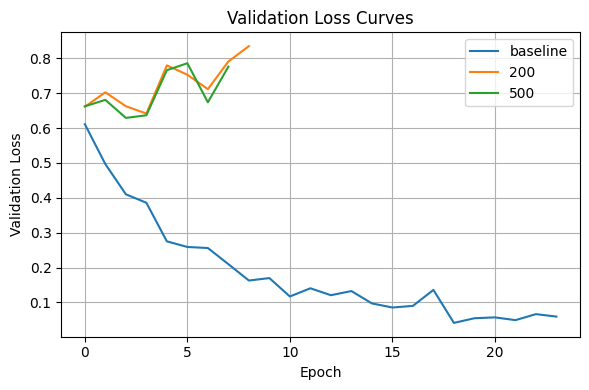

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
for key, (tr, vl) in all_train_losses.items():
    plt.plot(vl, label=str(key))
plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.title("Validation Loss Curves")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


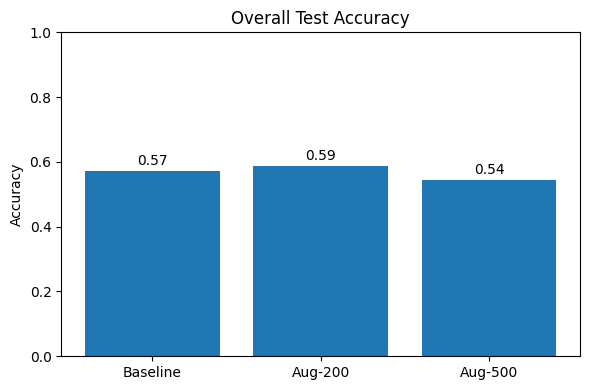

In [28]:


acc_base = np.mean(np.array(y_true_base) == np.array(y_pred_base))
acc_200  = np.mean(np.array(y_true_200)  == np.array(y_pred_200))
acc_500  = np.mean(np.array(y_true_500)  == np.array(y_pred_500))

labels = ["Baseline", "Aug-200", "Aug-500"]
accs   = [acc_base, acc_200, acc_500]

plt.figure(figsize=(6,4))
bars = plt.bar(labels, accs)
plt.ylim(0,1)
plt.ylabel("Accuracy")
plt.title("Overall Test Accuracy")
for bar, v in zip(bars, accs):
    plt.text(bar.get_x() + bar.get_width()/2, v + 0.02, f"{v:.2f}", ha='center')
plt.tight_layout()
plt.show()


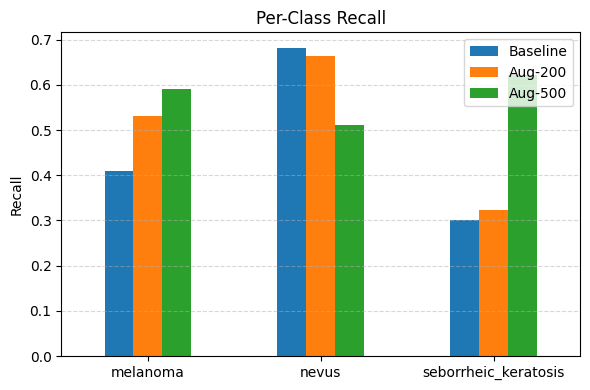

In [29]:
import pandas as pd


df = pd.DataFrame({
    "Baseline": list(per_class_acc_baseline.values()),
    "Aug-200":  list(per_class_acc_200.values()),
    "Aug-500":  list(per_class_acc_500.values())
}, index=real_ds.classes)

ax = df.plot.bar(figsize=(6,4), rot=0)
ax.set_ylabel("Recall")
ax.set_title("Per-Class Recall")
ax.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [30]:
torch.save(model.state_dict(), str(BASE / 'final_resnet18_dcgan_aug_S.pth'))
print("Saved augmented model weights")

Saved augmented model weights


In [18]:
print("hi")

hi


In [ ]:
import torchvision.utils as vutils

out_dir = SYN_ROOT / 'melanoma'
out_dir.mkdir(exist_ok=True, parents=True)

generator.eval()
noise = torch.randn(500, nz, 1, 1, device=device)
fake_imgs = generator(noise).cpu()
fake_imgs = (fake_imgs + 1) / 2     # rescale [-1,1]→[0,1]

for i, img in enumerate(fake_imgs):
    vutils.save_image(img, out_dir / f"dcgan_{i:03d}.png")
print(" Generated 500 synthetic melanoma images")


 Generated 500 synthetic melanoma images
